# Re-implementation of ''DreamDiffusion: Generating High-Quality Images from Brain EEG Signals'' by Y. Bai, X. Wang et al.
*By Daniele Santino Cardullo | 2127806 | cardullo.2127806@studenti.uniroma1.it*

*original work: [DreamDiffusion (arXiv)](https://arxiv.org/abs/2306.16934)*

## Abstract
DreamDiffusion is a method for generating images directly from electroencephalogram signals. This is achieved by combinating different methodologies such as: self-supervised learning to learn meaningful and efficient latent representations for signals; latent diffusion generative model to generate high quality images; large language model to align signals embeddings with image-text ones.

## Description of the implemented models and architectures

## How to run my code
In order to run the code it is necessary to download the files from the links in the next section and place them in the same folder as this notebook. The resulting directory tree should look like this:

<pre>
📦 nn_project_dreamdiffusion
├─ .gitignore
├─ README.md
├─ default_config.yaml
├─ requirements.txt
├─ solution_description.ipynb
├─ datasets
│  ├─ finetune_images/
│  ├─ finetune_dataset.pth
│  └─ pretrain_dataset.pth
├─ pretrained_models
│  ├─ pretrained_mae.ckpt
│  ├─ finetuned_eeg_encoder.pth
│  ├─ finetuned_unet.pth
│  ├─ finetuned_projector_tau.pth
│  └─ train_loss_mae.csv
└─ source
   ├─ datasets
   │  ├─ finetuning_dataset
   │  └─ pretraining_dataset.py
   ├─ eeg_diffusion
   │  ├─ dream_diffusion.
   │  └─ projector.py
   └─ eeg_mae
      ├─ attention_block.py
      ├─ eeg_autoencoder.py
      ├─ encoder_config.py
      ├─ masked_decoder.py
      ├─ masked_encoder.py
      └─ masked_loss.py
</pre>

It is also reccomended to create a `pip` virtual environment and install all the required dependencies in `requirements.txt` file.

## Implementation
### Downloads
Here are some links to download the datasets and pretrained models (extract them in the same folder where this notebook is):
- pretrained_models folder: 
- datasets folder:

`Using the already pretrained model` block you'll find at the end of every step is intended to be standalone hence can be run without running the precedings blocks. 

### First stage: Pretraining
The first stage in this work is the construction and pretraining of the *masked autoencoder for EEG signals*.
The datasets used for pretraining are selected from the MOABB family, a set of workbench for brain-computer interfaces development. In this implementation the model has been scaled with respect to the original work, still achieving good results both in terms of pretraining performances and final results.

The first step for pretraining is to load the datasets that will be used, in this case 5 subjects are selected from `BI2015b` dataset and 2 subjects are selected from `Lee2019_SSVEP`. The data is preprocessed in the dataset creation, filtering the signals between 5-95 Hz and limiting their timestep to 500 ticks; also each signal has been padded to have 128 channels by repeating it.

In [ ]:
import torch
from lightning.pytorch import seed_everything
from source.datasets.pretraining_dataset import EegPretrainDataset
from hydra import compose, initialize

with initialize(version_base=None, config_path="./", job_name="dream_diffusion"):
    cfg = compose(config_name="default_config")

# Seeding for repeatability
generator = torch.manual_seed(cfg.pretrain.seed)
seed_everything(cfg.pretrain.seed, workers=True)

ds = EegPretrainDataset(
    dim=cfg.pretrain.time_dimension, 
    train_perc=cfg.pretrain.train_perc)  # Preparation of the dataset (loading of data and preprocessing)

train_ds, test_ds = ds()    # Train and Test splitting

After having loaded the dataset it is possible to create the dataloaders for training and testing, in order to automatically create batches.

In [ ]:
from torch.utils.data import DataLoader


train_dl = DataLoader(train_ds, shuffle=True, batch_size=cfg.pretrain.bsz, generator=generator, num_workers=11)
test_dl = DataLoader(test_ds, batch_size=cfg.pretrain.bsz, generator=generator, num_workers=11)

After having loaded the data, we can finally instance the MAE model, along with the trainer. In this project Lightning has been used to enhance the training process limiting all the boilerplate code.

In [ ]:
from source.eeg_mae.masked_decoder import MaskedDecoder
from source.eeg_mae.masked_encoder import MaskedEncoder
from source.eeg_mae.encoder_config import EncoderConfig
from source.eeg_mae.eeg_autoencoder import EegAutoEncoder
from lightning.pytorch import Trainer

config = EncoderConfig(time_dim=cfg.pretrain.time_dimension, 
                       token_num=cfg.pretrain.time_dimension//4, 
                       embed_dim=cfg.mae.embed_dim, 
                       encoder_depth=cfg.mae.encoder_depth, 
                       encoder_heads=cfg.mae.encoder_heads, 
                       mask_perc=cfg.mae.mask_perc)
encoder = MaskedEncoder(config)
decoder = MaskedDecoder(cfg.pretrain.time_dimension, 
                        cfg.pretrain.time_dimension//4, 
                        cfg.mae.channels, 
                        cfg.mae.embed_dim,
                        cfg.mae.decoder_depth, 
                        cfg.mae.decoder_heads)

model = EegAutoEncoder(encoder, decoder, learning_rate=cfg.pretrain.lr)
trainer = Trainer(
    max_epochs=cfg.pretrain.epochs,
    log_every_n_steps=1,
    deterministic=True,
    enable_checkpointing=True, 
    gradient_clip_val=0.5,
    check_val_every_n_epoch=1
    )

And now it is possible to start the pretraining process:

In [ ]:
%tensorboard --logdir ./lightning_logs

In [ ]:
trainer.fit(model, train_dl, val_dataloaders=train_dl)

#### Using the already pretrained model
If you have downloaded the `pretrained_models` and `datasets` folders from the link in `Downloads` section, it is possible to directly load the already pretrained model and test it.

In [1]:
"""
Dataset Loading
"""
import torch
from lightning.pytorch import seed_everything
from source.datasets.pretraining_dataset import EegPretrainDataset
from hydra import compose, initialize
from source.eeg_mae.masked_decoder import MaskedDecoder
from source.eeg_mae.masked_encoder import MaskedEncoder
from source.eeg_mae.encoder_config import EncoderConfig
from source.eeg_mae.eeg_autoencoder import EegAutoEncoder
from lightning.pytorch import Trainer
from hydra import compose, initialize

with initialize(version_base=None, config_path="./", job_name="dream_diffusion"):
    cfg = compose(config_name="default_config")

generator = torch.manual_seed(cfg.pretrain.seed)
seed_everything(cfg.pretrain.seed, workers=True)

ds = EegPretrainDataset(
    dim=cfg.pretrain.time_dimension, 
    train_perc=cfg.pretrain.train_perc, ds_path='./datasets/pretrain_dataset.pth')

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
/home/osusume/Desktop/nn_project_dreamdiffusion/.venv/lib/python3.10/site-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.


Seed set to 0


Dataset loaded from file


In [4]:
"""
Model Loading
"""
from torch.utils.data import DataLoader

train_ds, test_ds = ds()
train_dl = DataLoader(train_ds, shuffle=True, batch_size=cfg.pretrain.bsz, generator=generator, num_workers=11)
test_dl = DataLoader(test_ds, batch_size=cfg.pretrain.bsz, generator=generator, num_workers=11)

config = EncoderConfig(time_dim=cfg.pretrain.time_dimension, 
                       token_num=cfg.pretrain.time_dimension//4, 
                       embed_dim=cfg.mae.embed_dim, 
                       encoder_depth=cfg.mae.encoder_depth, 
                       encoder_heads=cfg.mae.encoder_heads, 
                       mask_perc=cfg.mae.mask_perc)
encoder = MaskedEncoder(config)
decoder = MaskedDecoder(cfg.pretrain.time_dimension, 
                        cfg.pretrain.time_dimension//4, 
                        cfg.mae.channels, 
                        cfg.mae.embed_dim,
                        cfg.mae.decoder_depth, 
                        cfg.mae.decoder_heads)

model = EegAutoEncoder.load_from_checkpoint('./pretrained_models/pretrained_mae.ckpt', encoder=encoder, decoder=decoder, learning_rate=2.5e-3)

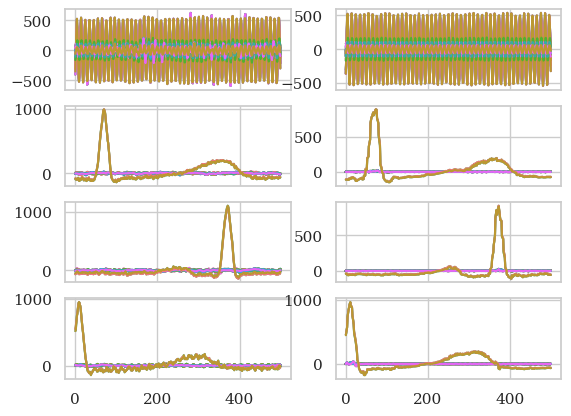

In [16]:
"""
Results
"""
import matplotlib.pyplot as plt

batch = next(iter(test_dl))
model.eval()

with torch.no_grad():
    prediction = model(batch.to('cuda')).detach().cpu()
    
fig, axes = plt.subplots(4, 2, sharex=True)

for i in range(4):
    axes[i, 0].plot(batch[i, :, :])
    axes[i, 1].plot(prediction[i, :, :])

plt.show()

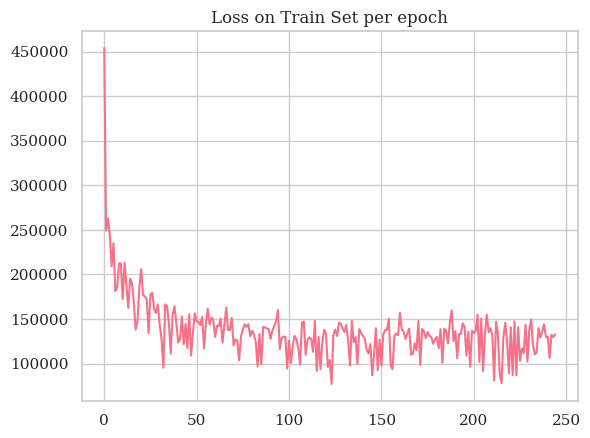

In [12]:
import pandas as pd 

df = pd.read_csv('./pretrained_models/train_loss_mae.csv', sep=',')

plt.plot(df['Value'])
plt.title('Loss on Train Set per epoch')
plt.show()

### Second Stage: CLIP - EEG Embeddings Alignment and SD Finetuning
The second step to make DreamDiffusion work is to align the eeg-embeddings produced by the pretrained encoder with the embeddings produced by CLIP-model for the corresponding images.

StableDiffusion finetuning is also performed together with CLIP-alignment.

This step is very GPU-memory consuming hence a high-end GPU is required. This is the reason why in this work the alignment has been performed for only 30 epochs, which are not sufficient to obtain good results on image generation.

In [ ]:
import sys
sys.path.append('../')

from accelerate import Accelerator
from diffusers import UNet2DConditionModel, AutoencoderKL, PNDMScheduler
from torch.utils.data import DataLoader
import clip
import torch
import torchvision.transforms as T
import torch.nn.functional as F
from lightning.pytorch import seed_everything

from source.datasets.finetuning_dataset import EegImageDataset
from source.eeg_diffusion.projector import Projector
from tqdm.auto import tqdm


seed_everything(0)
model_id = 'runwayml/stable-diffusion-v1-5'

The first step towards finetuning is obviously to load the pretrained models, in this work `runawayml/stable-diffusion-v1-5` from HuggingFace has been used together with the `diffusers` library.

In [ ]:
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder='unet')
vae = AutoencoderKL.from_pretrained(model_id, subfolder='vae')
scheduler = PNDMScheduler.from_pretrained(model_id, subfolder='scheduler')

In order to be able to run this code on less powerful GPUs `accelerate` library has also been used, integrating mixed precision and gradient accumulation, thoug more than 25 GB GPU RAM is still needed.

In [ ]:
# Creating accelerator for a better memory management
accelerator = Accelerator(gradient_accumulation_steps=4, mixed_precision='fp16')

Then there is the loading of the finetuning dataset and of the pretrained models and projectors.

In [ ]:
dataset = EegImageDataset(ds_folder='./datasets')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [ ]:
config = EncoderConfig('eeg encoder', 500, 500//4, 128, 256, 0.75, 4, 8)
encoder = MaskedEncoder(config)
decoder = MaskedDecoder(500, 500//4, 128, 256, 2, 4, 0)
eeg_embedder = EegAutoEncoder.load_from_checkpoint('./pretrained_models/pretrained_mae.ckpt', map_location='cpu', encoder=encoder, decoder=decoder, learning_rate=2.5e-3)
eeg_encoder = eeg_embedder.encoder

projector_tau = Projector(256, (77, 768))
projector_h = Projector(768, 768, token_num=77)

Loading the CLIP model is one of the most memory-consuming steps due to the high number of its parameters. A transformation `CenterCrop` is also needed to adapt images to CLIP input.

In [ ]:
clip_model, _ = clip.load("ViT-L/14", device=accelerator.device)
crop = T.CenterCrop((224, 224))

In [ ]:
vae.requires_grad = False
clip_model.requires_grad = False
projector_h.requires_grad = False

eeg_encoder.train()
projector_tau.train()
unet.train()
print('')

After loading all the models we define the optimizer and prepare the models to be trained through the accelerator, and start the training loop.

In [ ]:
optimizer = torch.optim.AdamW(list(eeg_encoder.parameters()) + list(projector_tau.parameters())
                                + list(unet.parameters()), lr=1.0e-5)

In [ ]:
(dataloader, unet, vae, scheduler, optimizer, projector_tau,
    eeg_encoder, clip_model, crop) = accelerator.prepare(dataloader, unet, vae, scheduler, optimizer, projector_tau,
                                                                    eeg_encoder, clip_model, crop)

In [ ]:
history_loss = []

In [ ]:
try:
    for e in range(30):
        print(f'Epoch {e + 1}/30')

        for b in tqdm(dataloader):
            eeg = b[0]
            image = b[1]
            with accelerator.accumulate(unet, projector_tau, eeg_encoder):
                embeddings, _, _ = eeg_encoder(eeg)
                hidden_states = projector_tau(embeddings)  # 77 x 768

                latents = vae.encode(image).latent_dist.sample()
                latents = latents * vae.config.scaling_factor

                noise = torch.randn_like(latents).to(accelerator.device)

                bsz = latents.shape[0]

                timesteps = torch.randint(0, 1000, (bsz,), device=accelerator.device)
                timesteps = timesteps.long()

                noisy_latents = scheduler.add_noise(latents.float(), noise.float(), timesteps)

                pred = unet(noisy_latents, timesteps, hidden_states, return_dict=False)[0]
                loss_unet = F.mse_loss(pred, noise, reduction='mean')

                # clip alignment
                image = crop(image)
                image_encodings = clip_model.encode_image(image)

                projection = projector_h(hidden_states)

                loss_clip = 1 - F.cosine_similarity(image_encodings, projection).sum(0) / bsz

                loss = loss_unet + loss_clip
                history_loss.append(loss.detach().cpu())

                accelerator.backward(loss)
                optimizer.step()
                optimizer.zero_grad()
except Exception as e:
    print(e)
    print('Training interrupted')
finally:
    print('saving model')
    torch.save(unet.state_dict(), './pretrained_models/finetuned_unet.pth')
    torch.save(eeg_encoder.state_dict(), './pretrained_models/finetuned_eeg_encoder.pth')
    torch.save(projector_tau.state_dict(), './pretrained_models/finetuned_projector_tau.pth')
    torch.save(history_loss(), './pretrained_models/finetune_loss.pth')
    print('model saved')

#### Using the already pretrained model

In [1]:
import torch
from diffusers import UNet2DConditionModel, AutoencoderKL, PNDMScheduler
from source.eeg_diffusion.projector import Projector
from source.eeg_mae.masked_encoder import MaskedEncoder
from source.eeg_mae.encoder_config import EncoderConfig
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from source.datasets.finetuning_dataset import EegImageDataset
from torch.utils.data import DataLoader

In [2]:
ds = EegImageDataset('./datasets')

  0%|          | 0/11965 [00:00<?, ?it/s]

  0%|          | 0/1996 [00:00<?, ?it/s]

  0%|          | 0/1996 [00:00<?, ?it/s]

  0%|          | 0/1996 [00:00<?, ?it/s]

Invalid Image: ./datasets/finetune_images/n03452741/n03452741_17620.JPEG
Generating Splits


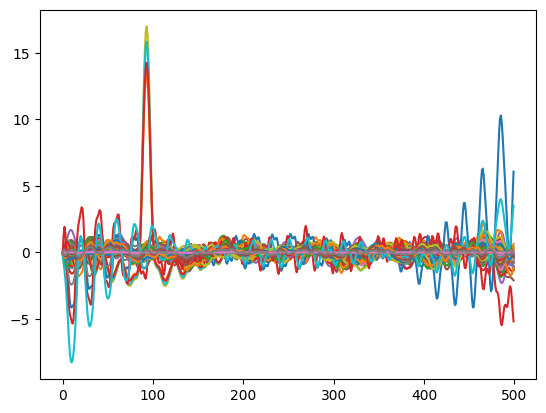

In [3]:
eeg, image = ds[torch.randint(0, len(ds), (1, ))]

eeg = eeg
image = image.unsqueeze(0)

plt.plot(eeg)

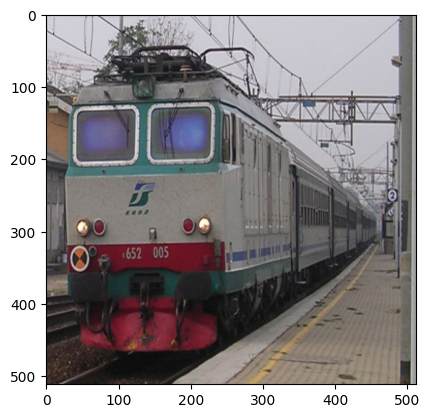

In [4]:
plt.imshow(image[0].permute(1, 2, 0))

In [5]:
model_id = 'runwayml/stable-diffusion-v1-5'
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder='unet')
unet.load_state_dict(torch.load('./pretrained_models/finetuned_unet.pth', map_location='cpu'))

vae = AutoencoderKL.from_pretrained(model_id, subfolder='vae')
scheduler = PNDMScheduler.from_pretrained(model_id, subfolder='scheduler')

unet.eval()
vae.eval()

print('Stable Diffusion loaded successfully')

Stable Diffusion loaded successfully


In [6]:
config = EncoderConfig('eeg encoder', 500, 500//4, 128, 256, 0.75, 4, 8)
encoder = MaskedEncoder(config)

encoder.load_state_dict(torch.load('./pretrained_models/finetuned_eeg_encoder.pth', map_location='cpu'))
tau = Projector(256, (77, 768))
tau.load_state_dict(torch.load('./pretrained_models/finetuned_projector_tau.pth', map_location='cpu'))

encoder.eval()
tau.eval()
print('Encoder and projector loaded successfully')

Encoder and projector loaded successfully


In [7]:
IMAGE_NUM = 5

if len(eeg.shape) < 3:
    eeg = torch.stack([eeg] * IMAGE_NUM)
print(eeg.shape)
encodings, _, _ = encoder(eeg)
hidden_states = tau(encodings)

latents = torch.randn((IMAGE_NUM, unet.config.in_channels, 64, 64), device='cuda')
scheduler.set_timesteps(500)

unet.to('cuda')
for t in tqdm(scheduler.timesteps):
    latents = scheduler.scale_model_input(latents, timestep=t)
    
    with torch.no_grad():
        noise_pred = unet(latents, t, encoder_hidden_states=hidden_states.to('cuda')).sample
    
    latents = scheduler.step(noise_pred, t, latents).prev_sample
    
unet.to('cpu')
latents = latents.to('cpu')
latents = latents / vae.config.scaling_factor

torch.Size([5, 500, 128])


  0%|          | 0/501 [00:00<?, ?it/s]

In [8]:
with torch.no_grad():
    image = vae.decode(latents).sample
    
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")

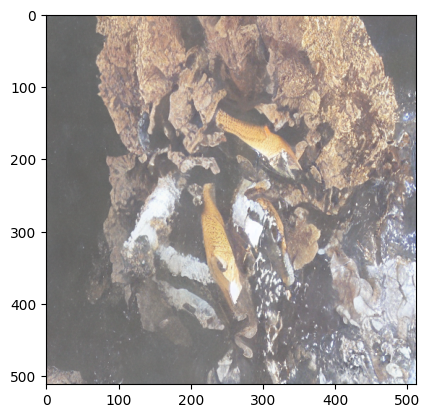

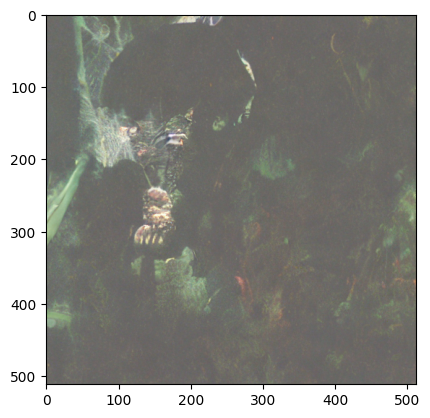

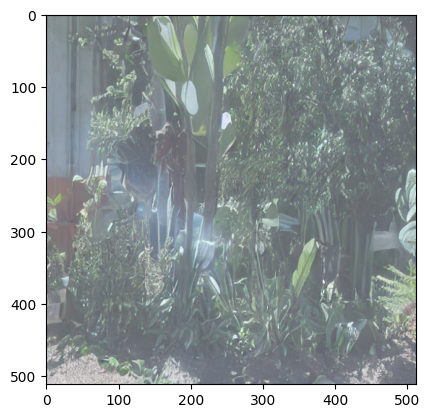

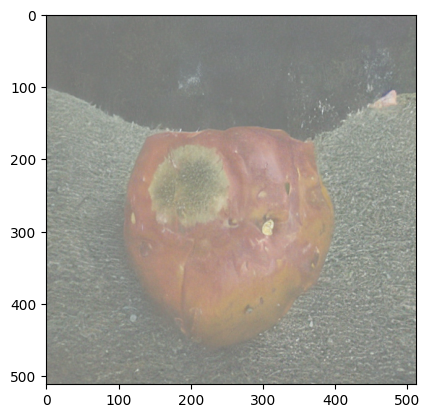

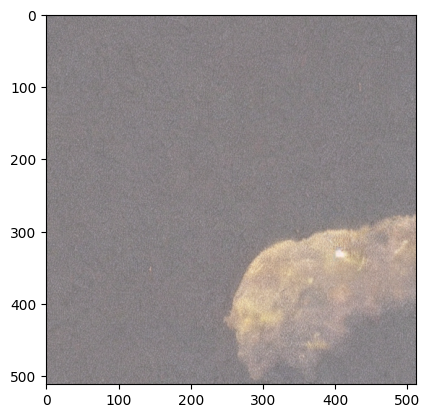

In [9]:
for i in images:
    plt.imshow(i / 255.0)
    plt.show()

### References
1. 
2. 